In [ ]:
#先ずは準備部分。ここで主なモデルはtennsorflowのMobileNet()関数とtensorflow_model_optimizationモデル
#本実験では互換性を確保するために、TensorFlow 2.13.0(古いバッジュン) 使用し、安定した環境下での再現を試みる。
#本研究においては、旧バージョンのTensorFlowおよびKerasを用いたモジュールの再現実験を行う必要がある。しかし、これらの旧バージョンは最新のモジュールとの互換性に制限があるため、他のプロジェクト環境に影響を与えないように配慮する必要がある。そのため、本実験専用に「kenkyu1」という名称の仮想環境（virtual environment）を新たに構築し、依存関係を分離した形で再現性と安定性を確保する。

In [1]:
#仮想環境検定
import sys
print(sys.executable)

C:\Users\chenyan\miniconda3\envs\kenkyu1\python.exe


In [2]:
#古いバッジュンのtensorflow、tensorflow_model_optimizationをインストールする
!pip install tensorflow==2.13.0
!pip install keras==2.13.1
!pip install tensorflow-model-optimization==0.7.5

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached keras-2.13.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
   ---------------------------------------- 0.0/276.5 MB ? eta -:--:--
    --------------------------------------- 6.0/276.5 MB 33.5 MB/s eta 0:00:09
   - -------------------------------------- 7.9/276.5 MB 20.3 MB/s eta 0:00:14
   - -------------------------------------- 10.5/276.5 MB 19.3 MB/s eta 0:00:14
   - -------------------------------------- 10.5/276.5 MB 19.3 MB/s eta 0:00:14
   - -------------------------------------- 12.6/276.5 MB 12.5 MB/s eta 0:00:22
   -- -------------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
exceptiongroup 1.3.0 requires typing-extensions>=4.6.0; python_version < "3.13", but you have typing-extensions 4.5.0 which is incompatible.
ipython 8.36.0 requires typing_extensions>=4.6; python_version < "3.12", but you have typing-extensions 4.5.0 which is incompatible.


  Using cached tensorflow_model_optimization-0.7.5-py2.py3-none-any.whl.metadata (914 bytes)
  Using cached absl_py-1.4.0-py3-none-any.whl.metadata (2.3 kB)
Using cached tensorflow_model_optimization-0.7.5-py2.py3-none-any.whl (241 kB)
Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)

  Attempting uninstall: absl-py

    Found existing installation: absl-py 2.2.2

    Uninstalling absl-py-2.2.2:

      Successfully uninstalled absl-py-2.2.2

   -------------------------- ------------- 2/3 [tensorflow-model-optimization]
   -------------------------- ------------- 2/3 [tensorflow-model-optimization]
   ---------------------------------------- 3/3 [tensorflow-model-optimization]



In [5]:
#サンプルデ-タの設定
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 24s 0us/step


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------  7.9/8.1 MB 40.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 38.4 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 31.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 30.9 MB/s eta 0:00:00

   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----------------- ---------------------- 3/7 [fonttools]
   ----------------- ---------------------- 3/7 [fonttools]
   ----------------- ---------------------- 3/7 [fonttools]
   ----------------- ---------------------- 3/7 [fonttools]
   ----------

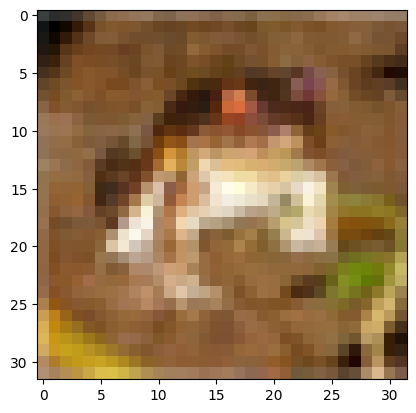

In [7]:
#サンプルデ-タ検定
#仮想環境なのでmatplotlibをインストールが必要
!pip install matplotlib
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
print(y_train[0])

In [15]:
#第２段階。モデルを構造すると訓練する(MobileNetV2)
#先ずはモデルを導入する。
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
# ラベルをワンホットエンコーディングに変換
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# 入力データを正規化（0〜1の範囲にスケーリング）
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# モデル構築：MobileNetV2ベースの軽量モデルを定義
base_model = MobileNetV2(weights=None, include_top=False, input_shape=(32, 32, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# モデルのコンパイル：損失関数にクロスエントロピー、最適化にAdamを使用
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# モデルの訓練：訓練データの90％を使用し、5エポックで学習（実験簡略化のため）
model.fit(x_train, y_train_cat, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5
704/704 [==============================] - 58s 74ms/step - loss: 1.9465 - accuracy: 0.2848 - val_loss: 2.3298 - val_accuracy: 0.1038
Epoch 2/5
704/704 [==============================] - 52s 74ms/step - loss: 1.5903 - accuracy: 0.4191 - val_loss: 2.4093 - val_accuracy: 0.0970
Epoch 3/5
704/704 [==============================] - 53s 75ms/step - loss: 1.4703 - accuracy: 0.4746 - val_loss: 2.3889 - val_accuracy: 0.1038
Epoch 4/5
704/704 [==============================] - 52s 74ms/step - loss: 1.4107 - accuracy: 0.4998 - val_loss: 2.3962 - val_accuracy: 0.1058
Epoch 5/5
704/704 [==============================] - 51s 73ms/step - loss: 1.2562 - accuracy: 0.5541 - val_loss: 2.4177 - val_accuracy: 0.1038


In [16]:
#第３段階。重みのプルーニング（pruning）
import numpy as np
import tensorflow_model_optimization as tfmot

# 1. プルーニングの設定（スパース率を0%から50%まで段階的に増加）
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.5,
        begin_step=0,
        end_step=np.ceil(len(x_train) / 64).astype(np.int32) * 5
    )
}

# 2. プルーニング対応のモデルを構築
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# 3. モデルを再コンパイル（プルーニング後は再定義が必要）
pruned_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# 4. プルーニングステップ更新のコールバックを追加（スパース化の進行を管理）
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()
]

# 5. Fine-tuning（微調整）を数エポック実行して性能を維持
pruned_model.fit(
    x_train, y_train_cat,
    batch_size=64,
    epochs=5,
    validation_split=0.1,
    callbacks=callbacks
)

Epoch 1/5
704/704 [==============================] - 75s 78ms/step - loss: 1.2521 - accuracy: 0.5581 - val_loss: 2.4978 - val_accuracy: 0.0950
Epoch 2/5
704/704 [==============================] - 54s 77ms/step - loss: 1.1188 - accuracy: 0.6048 - val_loss: 2.8564 - val_accuracy: 0.1368
Epoch 3/5
704/704 [==============================] - 55s 77ms/step - loss: 1.0296 - accuracy: 0.6365 - val_loss: 3.1697 - val_accuracy: 0.1618
Epoch 4/5
704/704 [==============================] - 55s 78ms/step - loss: 0.9332 - accuracy: 0.6711 - val_loss: 2.0909 - val_accuracy: 0.3796
Epoch 5/5
704/704 [==============================] - 55s 78ms/step - loss: 0.8515 - accuracy: 0.7013 - val_loss: 2.9672 - val_accuracy: 0.3742


In [18]:
# プルーニング用のラッパー構造を削除し、標準的なKerasモデル形式に変換
final_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

# モデルを保存（今後の量子化処理やTFLite変換に使用可能）
final_model.save('pruned_model.h5')

In [19]:
#第4段階。量子化（Quantization）
# TFLiteConverter を使って量子化を適用
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)

# デフォルト設定：重みをfloat32 → int8に変換（Post-Training Dynamic Range Quantization）
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 量子化されたTFLiteモデルを生成
tflite_quant_model = converter.convert()

# ファイルとして保存
with open('pruned_quantized_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)

print("量子化された TFLite モデルが保存されました：pruned_quantized_model.tflite")

INFO:tensorflow:Assets written to: C:\Users\chenyan\AppData\Local\Temp\tmpf8aj9qbq\assets


INFO:tensorflow:Assets written to: C:\Users\chenyan\AppData\Local\Temp\tmpf8aj9qbq\assets


量子化された TFLite モデルが保存されました：pruned_quantized_model.tflite


In [21]:
#大きさを比べる
import os

size_h5 = os.path.getsize('pruned_model.h5') / 1024 / 1024
size_tflite = os.path.getsize('pruned_quantized_model.tflite') / 1024 / 1024

print(f"puring model （.h5）：{size_h5:.2f} MB")
print(f"puring + Quantization model（.tflite）：{size_tflite:.2f} MB")

puring model （.h5）：9.13 MB
puring + Quantization model（.tflite）：2.40 MB


In [24]:
#第5段階。精度比較
# モデルを再コンパイル（必要：strip_pruning後はoptimizer等が失われる）
final_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
loss, acc = final_model.evaluate(x_test, y_test_cat)
print(f"puringmodel精度：{acc:.4f}")
import numpy as np
import tensorflow as tf
import time

# 量子化された TFLite モデルを読み込む
interpreter = tf.lite.Interpreter(model_path="pruned_quantized_model.tflite")
interpreter.allocate_tensors()

# 入力および出力テンソルの情報を取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 評価用に最初の100枚のテスト画像を準備（float32に変換）
test_samples = x_test[:100].astype(np.float32)
true_labels = y_test[:100]

# 推論処理と正答数のカウントを行う
correct = 0
start = time.time()
for i in range(len(test_samples)):
    input_data = np.expand_dims(test_samples[i], axis=0)  # 形状を (1, 32, 32, 3) に拡張
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    if predicted_label == true_labels[i][0]:
        correct += 1
end = time.time()

# 精度および平均推論時間（ms/画像）を算出
accuracy = correct / len(test_samples)
avg_infer_time = (end - start) / len(test_samples) * 1000  # 単位：ミリ秒

print(f" TFLite モデルの分類精度：{accuracy:.4f}")
print(f"平均推論時間：{avg_infer_time:.2f} ms/枚")

313/313 [==============================] - 4s 11ms/step - loss: 2.9560 - accuracy: 0.3829
puringmodel精度：0.3829
 TFLite モデルの分類精度：0.4200
平均推論時間：24.80 ms/枚
